In [60]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName('operations').enableHiveSupport().getOrCreate()
from pyspark.sql import *

In [4]:
import pandas as pd

In [5]:
import seaborn as sns

In [6]:
covdatapath="hdfs://localhost:9000/user/ayur/country_wise_latest.csv"

In [7]:
covdf = spark.read.csv(covdatapath, header='true', inferSchema='true')

In [8]:
covdf.show()

+-------------------+---------+------+---------+------+---------+----------+-------------+------------------+---------------------+----------------------+-------------------+-------------+-----------------+--------------------+
|     Country/Region|Confirmed|Deaths|Recovered|Active|New cases|New deaths|New recovered|Deaths / 100 Cases|Recovered / 100 Cases|Deaths / 100 Recovered|Confirmed last week|1 week change|1 week % increase|          WHO Region|
+-------------------+---------+------+---------+------+---------+----------+-------------+------------------+---------------------+----------------------+-------------------+-------------+-----------------+--------------------+
|        Afghanistan|    36263|  1269|    25198|  9796|      106|        10|           18|               3.5|                69.49|                  5.04|              35526|          737|             2.07|Eastern Mediterra...|
|            Albania|     4880|   144|     2745|  1991|      117|         6|           6

In [9]:
covdf.printSchema()

root
 |-- Country/Region: string (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Recovered: integer (nullable = true)
 |-- Active: integer (nullable = true)
 |-- New cases: integer (nullable = true)
 |-- New deaths: integer (nullable = true)
 |-- New recovered: integer (nullable = true)
 |-- Deaths / 100 Cases: double (nullable = true)
 |-- Recovered / 100 Cases: double (nullable = true)
 |-- Deaths / 100 Recovered: string (nullable = true)
 |-- Confirmed last week: integer (nullable = true)
 |-- 1 week change: integer (nullable = true)
 |-- 1 week % increase: double (nullable = true)
 |-- WHO Region: string (nullable = true)



In [10]:
import pyspark.sql.functions as func

In [11]:
from pyspark.sql.functions import col, floor

In [12]:
from pyspark.sql.types import IntegerType

In [13]:
df1=covdf.withColumn("col4",floor(func.round(covdf['Deaths / 100 Cases'])).cast('int'))

In [14]:
df1.show()

+-------------------+---------+------+---------+------+---------+----------+-------------+------------------+---------------------+----------------------+-------------------+-------------+-----------------+--------------------+----+
|     Country/Region|Confirmed|Deaths|Recovered|Active|New cases|New deaths|New recovered|Deaths / 100 Cases|Recovered / 100 Cases|Deaths / 100 Recovered|Confirmed last week|1 week change|1 week % increase|          WHO Region|col4|
+-------------------+---------+------+---------+------+---------+----------+-------------+------------------+---------------------+----------------------+-------------------+-------------+-----------------+--------------------+----+
|        Afghanistan|    36263|  1269|    25198|  9796|      106|        10|           18|               3.5|                69.49|                  5.04|              35526|          737|             2.07|Eastern Mediterra...|   4|
|            Albania|     4880|   144|     2745|  1991|      117|   

In [15]:
df1=df1.sort(col("col4").desc()).limit(10)

In [16]:
df1=df1.select("Country/Region","col4")

In [17]:
import matplotlib.pyplot as plt

In [18]:
df1=df1.toPandas()

In [19]:
x = df1['Country/Region']
y = df1['col4']

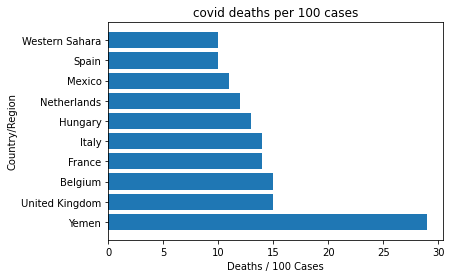

In [20]:
plt.barh(x,y)
plt.title('covid deaths per 100 cases')
plt.ylabel('Country/Region')
plt.xlabel('Deaths / 100 Cases')
plt.show()

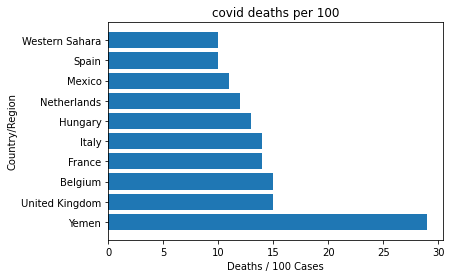

In [21]:
plt.barh(x,y)
plt.title('covid deaths per 100')
plt.ylabel('Country/Region')
plt.xlabel('Deaths / 100 Cases')
plt.show()

In [22]:
df2=covdf.withColumn("col4",floor(func.round(covdf['Recovered / 100 Cases'])).cast('int'))

In [23]:
df2=df2.sort(col("col4").desc()).limit(10)

In [24]:
df2=df2.select("Country/Region","col4")

In [25]:
df2=df2.toPandas()

In [26]:
x = df2['Country/Region']
y = df2['col4']

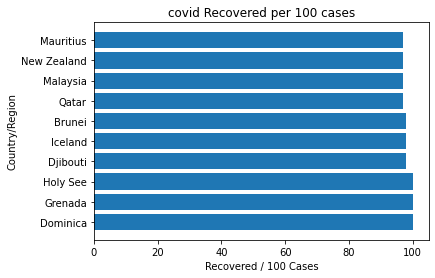

In [27]:
plt.barh(x,y)
plt.title('covid Recovered per 100 cases')
plt.ylabel('Country/Region')
plt.xlabel('Recovered / 100 Cases')
plt.show()

In [28]:
df3=covdf.withColumn("col4",floor(func.round(covdf['Deaths / 100 Recovered'])).cast('int'))

In [29]:
df3=df3.sort(col("col4").desc()).limit(10)

In [30]:
df3=df3.select("Country/Region","col4")

In [31]:
df3=df3.toPandas()

In [32]:
x = df3['Country/Region']
y = df3['col4']

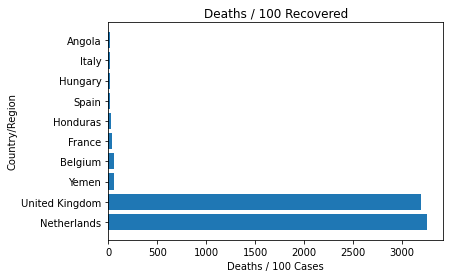

In [33]:
plt.barh(x,y)
plt.title('Deaths / 100 Recovered')
plt.ylabel('Country/Region')
plt.xlabel('Deaths / 100 Cases')
plt.show()

In [34]:
df4 = covdf.select("Country/Region","Confirmed","Deaths","Recovered").limit(10)

In [35]:
df4=df4.toPandas()

In [36]:
df4.to_pickle("dataframecov.pkl")

In [37]:
df5 = pd.read_pickle("dataframecov.pkl")

In [38]:
df5.head()

,Country/Region,Confirmed,Deaths,Recovered
0,Afghanistan,36263,1269,25198
1,Albania,4880,144,2745
2,Algeria,27973,1163,18837
3,Andorra,907,52,803
4,Angola,950,41,242


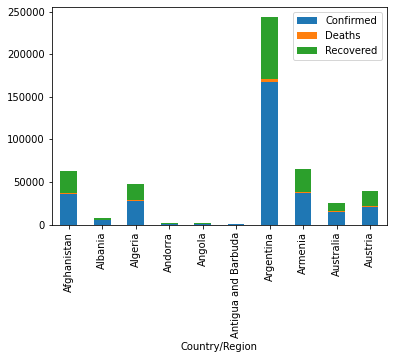

In [39]:
ax = df5.set_index('Country/Region').plot.bar(stacked=True)

<AxesSubplot:xlabel='Country/Region'>

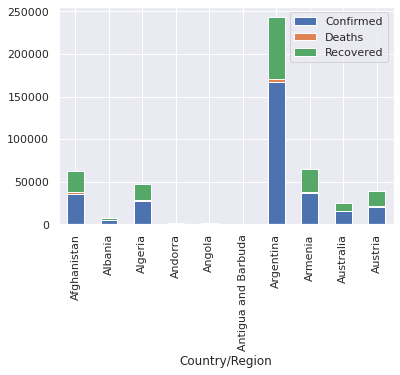

In [40]:
sns.set()
df5.set_index('Country/Region').plot(kind='bar', stacked=True)

In [41]:
df6 = covdf.select("Country/Region","New cases","New deaths","New recovered").limit(10)

In [42]:
type(df6)

pyspark.sql.dataframe.DataFrame

In [43]:
df6=df6.toPandas()

<AxesSubplot:xlabel='Country/Region'>

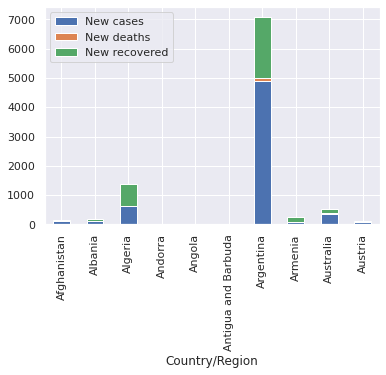

In [44]:
df6.set_index('Country/Region').plot.bar(stacked=True)

In [45]:
df7 = covdf.select("Country/Region","New cases","New deaths","New recovered").limit(10)

# saving spark dataframe to mysql

In [46]:
database = 'sparkOperations'
user = 'root'
password = 'Ayurn@6299'

In [47]:
jdbc_url = f"jdbc:mysql://localhost:3306/"+ database

df7.write.format('jdbc').option("url",jdbc_url) \
    .mode("overwrite") \
    .option("dbtable","covid_data") \
    .option("driver","com.mysql.jdbc.Driver") \
    .option("user",user).option("password",password).save()

Loading class `com.mysql.jdbc.Driver'. This is deprecated. The new driver class is `com.mysql.cj.jdbc.Driver'. The driver is automatically registered via the SPI and manual loading of the driver class is generally unnecessary.


loading data from mysql to spark df

In [58]:
covid_data1 = spark.read.format("jdbc") \
    .option("url","jdbc:mysql://localhost:3306/sparkOperations") \
    .option("driver","com.mysql.jdbc.Driver") \
    .option("dbtable","covid_data") \
    .option("user",user) \
    .option("password",password).load()

# saving spark dataframe to hive table

In [66]:
spark = SparkSession.builder.master("local").appName('operations').enableHiveSupport().getOrCreate()

In [63]:
spark.sql("show databases").show()
    

+---------+
|namespace|
+---------+
|  default|
+---------+



In [70]:
df8=covdf.select("Country/Region","Confirmed","Deaths","Recovered").limit(10)

## Save df to a new table in Hive

In [71]:
df8.write.mode("overwrite").saveAsTable("default.covData")

In [72]:
# Show the results using SELECT
spark.sql("select * from default.covData").show()

+-------------------+---------+------+---------+
|     Country/Region|Confirmed|Deaths|Recovered|
+-------------------+---------+------+---------+
|        Afghanistan|    36263|  1269|    25198|
|            Albania|     4880|   144|     2745|
|            Algeria|    27973|  1163|    18837|
|            Andorra|      907|    52|      803|
|             Angola|      950|    41|      242|
|Antigua and Barbuda|       86|     3|       65|
|          Argentina|   167416|  3059|    72575|
|            Armenia|    37390|   711|    26665|
|          Australia|    15303|   167|     9311|
|            Austria|    20558|   713|    18246|
+-------------------+---------+------+---------+

